In [291]:
import numpy as np
import matplotlib.pyplot as plt

import webbpsf
from statsmodels.regression.linear_model import WLS

from lenstronomy.Data.psf import PSF
from lenstronomy.Util import util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from astropy.io import fits
from astropy.table import Table
from uncertainties import unumpy as unp
from uncertainties import ufloat
from grizli import utils
from astropy import wcs as pywcs

import pandas as pd
from astropy.convolution import convolve
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=69.5, Om0=0.285, Ob0=0.0461)

import emcee, os
from scipy.optimize import minimize
from scipy import ndimage
import corner
from multiprocessing import Pool, cpu_count

## Reading in the data

In [314]:
root_path = '/Users/acharyya/Work/astro/passage/'
field = 'Par028' # 'glass-a2744'
objid = 2867 # 2867, 2727, 2128
re_limit = 2.5
Zdiag = 'NB'
filter_in_full_fits = 'F140W'

supersampling_factor = 1
fov_arcsec = 0.67
exptime = 500
filter = 'F150W'

In [315]:
survey = 'passage' if 'Par' in field else 'glass'
full_fitsname = root_path + f'/{survey}_data/v0.5/{field}/Products/maps/{field}_{objid:05d}.maps.fits'
if not os.path.exists(full_fitsname): full_fitsname = root_path + f'/{survey}_data/orig/{field}/Products/full/{field}_{objid:05d}.full.fits'
full_hdu = fits.open(full_fitsname)
try: hdu = full_hdu['DSCI', filter_in_full_fits] # for passage objects
except: hdu = full_hdu['DSCI', f'{filter}-{filter}-CLEAR'] # for glass objects
filter_image = hdu.data
pixel_scale = utils.get_wcs_pscale(pywcs.WCS(full_hdu['DSCI'].header))
z = full_hdu[0].header['redshift']

In [316]:
metallicity_fitsname = root_path + f'/{survey}_output/v0.5/catalogs/{field}_{objid:05d}_logOH_map_upto_{re_limit}re_onlyseg_vorbin_at_OII_SNR_3.0_Zdiag_{Zdiag}.fits'
if not os.path.exists(metallicity_fitsname): metallicity_fitsname = root_path + f'/{survey}_output/orig/catalogs/{field}_{objid:05d}_logOH_map_upto_{re_limit}re_onlyseg_vorbin_at_OII_SNR_3.0_Zdiag_{Zdiag}.fits'
hdul = fits.open(metallicity_fitsname)
hdu = hdul['log_OH']
logOH_map = np.ma.masked_where(np.isnan(hdu.data), unp.uarray(hdu.data, hdul['log_OH_u'].data))
logOH_map.data[np.isnan(unp.nominal_values(logOH_map.data))] = ufloat(0, 1e20)

logOH_df = Table(hdul['tab'].data).to_pandas()
logOH_df['distance'] *= cosmo.arcsec_per_kpc_proper(z).value # converting from kpc to arcsec

center_pix = int(np.shape(filter_image)[0] / 2)
farthest_pix = int(np.shape(logOH_map)[0] / 2)
light_map = filter_image[center_pix - farthest_pix : center_pix + farthest_pix, center_pix - farthest_pix : center_pix + farthest_pix]

## Use case #1: Forward-modelling the effects of psf smear

We can attempt to fit the metallicity gradient for this galaxy using weighted least squares (WLS) and the observed metallicity profile, but it won't be correct:

In [317]:
ones = np.ones(len(logOH_df))
covariates = np.vstack((ones, logOH_df['distance'])).T
wls_model_fit = WLS(logOH_df['log_OH'], covariates, weights=1/(logOH_df['log_OH_u']**2)).fit()

print(wls_model_fit.summary())

print("\nRecovered Zc = {0:.5}, gradZ = {1:.5} dex/arcsec.".format(*wls_model_fit.params))

                            WLS Regression Results                            
Dep. Variable:                 log_OH   R-squared:                       0.056
Model:                            WLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.362
Date:                Fri, 06 Jun 2025   Prob (F-statistic):              0.132
Time:                        15:52:29   Log-Likelihood:                -17.761
No. Observations:                  42   AIC:                             39.52
Df Residuals:                      40   BIC:                             43.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9789      0.121     66.084      0.0

In [318]:
# ---------making the PSF---------------
niriss = webbpsf.NIRISS()
niriss.filter = filter
niriss.pixelscale = pixel_scale
psf = niriss.calc_psf(fov_arcsec=fov_arcsec, oversample=supersampling_factor)
psf_array  = psf[0].data
psf_type   = 'PIXEL'
kwargs_psf = {'psf_type': psf_type, 'kernel_point_source':psf_array, 'point_source_supersampling_factor':supersampling_factor}

# --------generate the coordinate grid and image properties (we only read out the relevant lines we need)-----------
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=np.shape(logOH_map)[0], deltapix=pixel_scale, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

# ---------reading in observed light map-----------------------------
kwargs_image_data = {'background_rms':.005 ,  # rms of background noise; background noise per pixel
                    'exposure_time': exptime,  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
                    'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                    'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                    'image_data': light_map   # 2d data vector
                    }

# ---------reading in observed metallicity map-----------------------------
kwargs_tracer_data = {'noise_map': unp.std_devs(logOH_map.data),
                    'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
                    'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
                    'image_data': unp.nominal_values(logOH_map.data)}  # 2d data vector


We can visualise this galaxy's image and metallicity map:

Text(0.5, 1.0, 'PSF')

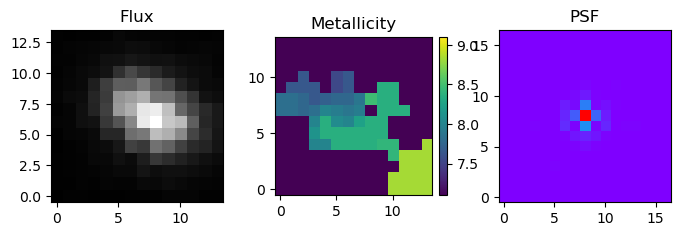

In [319]:
fig, axes = plt.subplots(1,3, figsize=(8, 3))
fig.subplots_adjust(wspace=0.3)
axes[0].imshow(kwargs_image_data['image_data'], cmap='Greys_r')
axes[0].set_title('Flux')
z_plot = axes[1].imshow(kwargs_tracer_data['image_data'], vmin=7.1, vmax=9.1)
axes[1].set_title('Metallicity')
plt.colorbar(z_plot,ax=axes[1],fraction=0.046, pad=0.04)
axes[2].imshow(kwargs_psf['kernel_point_source'], cmap='rainbow')
axes[2].set_title('PSF')

On the other hand, we can fit the metallicity gradient using forward-modelling with `lenstronomy`'s tracer module, for a much more accurate result:  
(expected run time: ~5 minutes. Make yourself a cup of tea!)

In [200]:
# ---------defining numeric kwargs-----------------------------
kwargs_numerics = {'supersampling_factor':supersampling_factor, 
                'point_source_supersampling_factor':supersampling_factor, 
                'supersampling_convolution': True}

# ---------defining lens model-----------------------------
lens_params = [[], [], [], [], []] # Since our model is no lens, use a bunch of empty lists

# ---------defining source model params-----------------------------
# Source params -- fixed to true input values; We know that lenstronomy can fit galaxy properties, we are not testing this here.
fixed_source        = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_init  = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_sigma = [{'amp': 1,  'R_sersic': 1, 'n_sersic': 1, 'e1': 1, 'e2': 1, 'center_x': 1, 'center_y': 1}]
kwargs_lower_source = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_upper_source = [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# ---------defining tracer model params-----------------------------
fixed_tracer_source = [{'center_x': 0, 'center_y': 0}]
kwargs_tracer_source_init  = [{'center_x': 0, 'center_y': 0, 'amp': 8, 'k': 0}] 
kwargs_tracer_source_sigma = [{'center_x': 2, 'center_y': 2, 'amp': 0.5, 'k': 0.3}]
kwargs_lower_tracer_source = [{'center_x': -10, 'center_y': -10, 'amp': 6,   'k': -1}]
kwargs_upper_tracer_source = [{'center_x': 10, 'center_y': 10, 'amp': 9,   'k': +1}]

tracer_source_params = [kwargs_tracer_source_init, kwargs_tracer_source_sigma, fixed_tracer_source, kwargs_lower_tracer_source, kwargs_upper_tracer_source]

# ---------combing all models-----------------------------
kwargs_params = {'lens_model': lens_params, 'source_model': source_params, 'tracer_source_model': tracer_source_params}           
kwargs_likelihood = {'source_marg': False, 'tracer_likelihood': True}
kwargs_model = {'lens_model_list': [], 'source_light_model_list': ['SERSIC_ELLIPSE'],  'tracer_source_model_list': ['LINEAR'], 'tracer_source_band': 0, 'tracer_partition':[[0,0]]}

# ---------fitting process-----------------------------
multi_band_list = [[kwargs_image_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list, 
                'multi_band_type': 'single-band',  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                'tracer_data': [kwargs_tracer_data, kwargs_psf, kwargs_numerics]}
kwargs_constraints = {'linear_solver': True}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['PSO',  {'sigma_scale': 1, 'n_particles': 100, 'n_iterations': 500}], ['MCMC', {'n_burn': 50, 'n_run': 1000, 'n_walkers': 100, 'sigma_scale': .1}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

print(kwargs_result)

Computing the PSO ...


 55%|█████▍    | 274/500 [00:13<00:11, 20.51it/s]


Converged after 274 iterations!
Best fit found:  -1354.0624610777083 [8.215107912259587, 0.9999999999999952]
-6.961760725335261 reduced X^2 of best position
-1354.0624610777083 log likelihood
389.0 effective number of data points
[] lens result
[{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}] source result
[] lens light result
[] point source result
[{'amp': 8.215107912259587, 'k': 0.9999999999999952, 'center_x': 0, 'center_y': 0}] tracer source result
{} special param result
13.362452983856201 time used for  PSO
MCMC selected. Sampling with default option emcee.


100%|██████████| 1050/1050 [01:25<00:00, 12.21it/s]

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  50
Sampling iterations (in current run): 1050
86.08315086364746 time taken for MCMC sampling
{'kwargs_lens': [], 'kwargs_source': [{'amp': 16, 'R_sersic': 1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': [{'amp': 8.215970219782237, 'k': 0.9999600856559823, 'center_x': 0, 'center_y': 0}]}


Much better! From the posteriors of our emcee chain we can get credible intervals and formal uncertainties on these fitted parameters, too:

In [201]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

lower_bound = np.percentile(samples_mcmc[:,1], 16)
median      = np.percentile(samples_mcmc[:,1], 50)
upper_bound = np.percentile(samples_mcmc[:,1], 84)
print("gradZ = {0:.4} (+{1:.4}/-{2:.4})".format(median, upper_bound - median, median-lower_bound))

lenstronomy_fit_params = [np.median(samples_mcmc[:, item]) for item in range(np.shape(samples_mcmc)[1])][::-1]

gradZ = 0.9838 (+0.01207/-0.02513)


Let's visualise the lenstronomy fit results

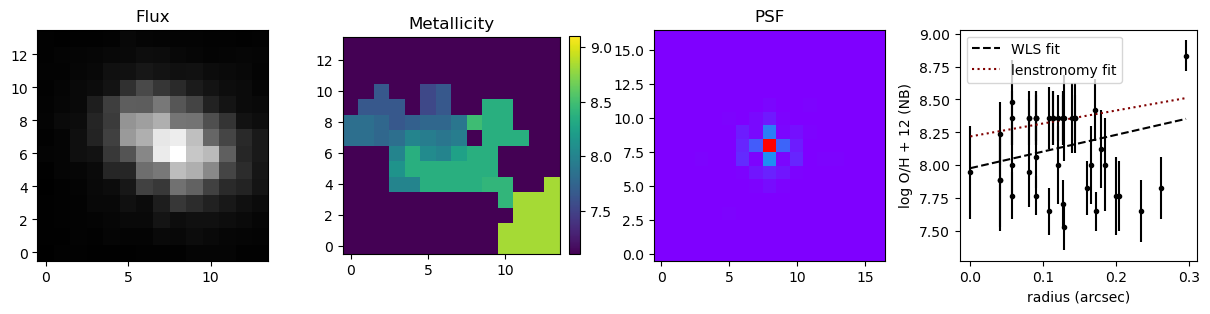

In [202]:
fig, axes = plt.subplots(1,4, figsize=(15, 3))
fig.subplots_adjust(wspace=0.3)

axes[0].imshow(kwargs_image_data['image_data'], cmap='Greys_r')
axes[0].set_title('Flux')

z_plot = axes[1].imshow(kwargs_tracer_data['image_data'], vmin=7.1, vmax=9.1)
axes[1].set_title('Metallicity')
plt.colorbar(z_plot,ax=axes[1],fraction=0.046, pad=0.04)

axes[2].imshow(kwargs_psf['kernel_point_source'], cmap='rainbow')
axes[2].set_title('PSF')

radprof_ax = axes[3]
xarr = np.linspace(np.min(logOH_df['distance']), np.max(logOH_df['distance']), 10)

radprof_ax.errorbar(logOH_df['distance'], logOH_df['log_OH'], yerr=logOH_df['log_OH_u'], fmt='.k', capsize=0)
radprof_ax.plot(xarr, np.poly1d([wls_model_fit.params['x1'], wls_model_fit.params['const']])(xarr), c='k', ls='--', label='WLS fit')
radprof_ax.plot(xarr, np.poly1d(lenstronomy_fit_params)(xarr), c='maroon', ls=':', label='lenstronomy fit')

radprof_ax.set_xlabel('radius (arcsec)')
radprof_ax.set_ylabel(f'log O/H + 12 ({Zdiag})')
radprof_ax.legend()
radprof_ax.set_aspect('auto')

## Now my method of MCMC on voronoi bins

Definiing the model and likelihood functions

In [255]:
def bin_2D(value_array, id_array):
    valid_ids = id_array.data[~id_array.mask].astype(int)
    valid_values = value_array[~id_array.mask]

    unique_ids = np.unique(valid_ids)
    means = ndimage.mean(valid_values, labels=valid_ids, index=unique_ids)

    lut = np.full(int(np.nanmax(id_array.data)) + 1, np.nan)
    lut[unique_ids] = means

    result_array = np.full(id_array.shape, np.nan)
    result_array[~id_array.mask] = lut[valid_ids]

    return result_array

def compute_model(params, light_map, psf_array, bin_IDs_map):
    # -------creating an elliptical metallicity map--------------
    center_pix = np.array(np.shape(light_map)) / 2.
    #center_pix = params[4:6] # now fitting for the center too
    y, x = np.indices(np.shape(light_map))
    x_rel = x - center_pix[0]
    y_rel = (y - center_pix[1]) / params[2]
    theta = np.radians(params[3])
    x_rel = x_rel * np.cos(theta) + y_rel * np.sin(theta)
    y_rel = -x_rel * np.sin(theta) + y_rel * np.cos(theta)

    distance_map = np.sqrt(x_rel ** 2 + y_rel ** 2) * pixel_scale # arcsec
    logOH_map_model = np.poly1d(params[:2])(distance_map)
    
    # ------smoothing metallicity model with PSF------------------
    logOH_map_model_smoothed = convolve(logOH_map_model, psf_array, boundary='extend')

    # -------voronoi binning the smoothed map as per given vorbin segmentation----------
    logOH_map_model_binned = bin_2D(logOH_map_model_smoothed, bin_IDs_map)
    logOH_df_model = pd.DataFrame({'distance': distance_map.flatten(), 'log_OH_model': logOH_map_model_binned.flatten(), 'bin_ID': bin_IDs_map.data.flatten().byteswap().newbyteorder()})
    logOH_df_model = logOH_df_model.dropna().reset_index(drop=True)
    logOH_df_model['bin_ID'] = logOH_df_model['bin_ID'].astype(int)
    logOH_df_model = logOH_df_model.groupby(['bin_ID'], as_index=False).agg('mean')

    return logOH_df_model, distance_map, logOH_map_model, logOH_map_model_smoothed, logOH_map_model_binned

def log_prior(params, bounds):
    for index, this_param in enumerate(params):
        if  this_param < bounds[index][0] or this_param > bounds[index][1]:
            return -np.inf

    return 0

def log_likelihood(params, logOH_df, light_map, psf_array, bin_IDs_map, bounds):
    lnpr = log_prior(params, bounds)
    if not np.isfinite(lnpr):
        return -np.inf
    
    x = logOH_df['distance']
    y = logOH_df['log_OH']
    yerr = logOH_df['log_OH_u']

    logOH_df_model, _, _, _, _= compute_model(params, light_map, psf_array, bin_IDs_map)
    logOH_df_merged = logOH_df.merge(logOH_df_model, on=['bin_ID'])
    model = logOH_df_merged['log_OH_model']

    log_like = -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) + np.log(2 * np.pi * yerr ** 2))

    return log_like

def make_all_plots(params):
    # ------computing the best model-----------
    logOH_df_best_model, distance_map_best, logOH_map_best_model, logOH_map_best_model_smoothed, logOH_map_best_model_binned = compute_model(params, light_map, psf_array, bin_IDs_map)

    # ------setting up figure---------
    fig2, axs = plt.subplots(2, 4, figsize=(16, 8))
    axes = axs.flatten()
    fig2.subplots_adjust(wspace=0.5, hspace=0.)

    # --------plotting 2D maps----------
    axes[0].imshow(light_map, cmap='Greys_r')
    axes[0].set_title('Flux data')

    z_plot = axes[1].imshow(np.ma.masked_where(logOH_map.mask, unp.nominal_values(logOH_map)), vmin=7.1, vmax=9.1)
    axes[1].set_title('Metallicity data')
    plt.colorbar(z_plot,ax=axes[1],fraction=0.046, pad=0.01)

    axes[2].imshow(psf_array, cmap='rainbow')
    axes[2].set_title('PSF')

    z_plot = axes[3].imshow(distance_map_best)
    axes[3].set_title('Distance\nbest model')
    plt.colorbar(z_plot,ax=axes[3],fraction=0.046, pad=0.01)

    z_plot = axes[4].imshow(logOH_map_best_model, vmin=7.1, vmax=9.1)
    axes[4].set_title('Metallicity\nbest model')
    plt.colorbar(z_plot,ax=axes[4],fraction=0.046, pad=0.01)

    z_plot = axes[5].imshow(logOH_map_best_model_smoothed, vmin=7.1, vmax=9.1)
    axes[5].set_title('Metallicity\nbest model smoothed')
    plt.colorbar(z_plot,ax=axes[5],fraction=0.046, pad=0.01)

    z_plot = axes[6].imshow(logOH_map_best_model_binned, vmin=7.1, vmax=9.1)
    axes[6].set_title('Metallicity\nbest model binned')
    plt.colorbar(z_plot,ax=axes[6],fraction=0.046, pad=0.01)

    # -------plotting radial profiles--------------
    # gs = axes[-2].get_gridspec()
    # axes[-2].remove()
    # axes[-1].remove()
    # radprof_ax = fig.add_subplot(gs[1, -2:])
    radprof_ax = axes[7]
    xarr = np.linspace(np.min(logOH_df['distance']), np.max(logOH_df['distance']), 10)

    radprof_ax.errorbar(logOH_df['distance'], logOH_df['log_OH'], yerr=logOH_df['log_OH_u'], fmt='.k', capsize=0)
    radprof_ax.plot(xarr, np.poly1d([wls_model_fit.params['x1'], wls_model_fit.params['const']])(xarr), c='k', ls='--', label='WLS fit')
    radprof_ax.plot(xarr, np.poly1d(params[:2])(xarr), c='maroon', ls=':', label='this model')
    radprof_ax.scatter(logOH_df_best_model['distance'], logOH_df_best_model['log_OH_model'], c='salmon', s=30, lw=0.5, ec='k', label='best model\nbinned', zorder=5)

    radprof_ax.set_xlabel('radius (arcsec)')
    radprof_ax.set_ylabel(f'log O/H + 12 ({Zdiag})')
    radprof_ax.legend()
    radprof_ax.set_aspect('auto')

    return fig

def make_param_plots(params):
    # ------computing the best model-----------
    logOH_df_best_model, distance_map_best, logOH_map_best_model, logOH_map_best_model_smoothed, logOH_map_best_model_binned = compute_model(params, light_map, psf_array, bin_IDs_map)

    # ------setting up figure---------
    fig2, axs = plt.subplots(1, 5, figsize=(14, 4))
    axes = axs.flatten()
    fig2.subplots_adjust(wspace=0.5, hspace=0.)

    # --------plotting 2D maps----------
    z_plot = axes[0].imshow(distance_map_best)
    axes[0].set_title('Distance\ninput model')
    plt.colorbar(z_plot,ax=axes[0],fraction=0.046, pad=0.01)

    z_plot = axes[1].imshow(logOH_map_best_model, vmin=7.1, vmax=9.1)
    axes[1].set_title('Metallicity\ninput model')
    plt.colorbar(z_plot,ax=axes[1],fraction=0.046, pad=0.01)

    z_plot = axes[2].imshow(logOH_map_best_model_smoothed, vmin=7.1, vmax=9.1)
    axes[2].set_title('Metallicity\ninput model smoothed')
    plt.colorbar(z_plot,ax=axes[2],fraction=0.046, pad=0.01)

    z_plot = axes[3].imshow(logOH_map_best_model_binned, vmin=7.1, vmax=9.1)
    axes[3].set_title('Metallicity\ninput model binned')
    plt.colorbar(z_plot,ax=axes[3],fraction=0.046, pad=0.01)

    # -------plotting radial profiles--------------
    radprof_ax = axes[4]
    radprof_ax.scatter(logOH_df_best_model['distance'], logOH_df_best_model['log_OH_model'], c='salmon', s=30, lw=0.5, ec='k', label='input model\nbinned', zorder=5)

    radprof_ax.set_xlabel('radius (arcsec)')
    radprof_ax.set_ylabel(f'log O/H + 12 ({Zdiag})')
    radprof_ax.legend()
    #radprof_ax.set_aspect('auto')

    return fig

Declaring emcee parameters and other static arguments

In [265]:
bin_IDs_map = hdul['bin_id'].data
bin_IDs_map = np.ma.masked_where(np.isnan(bin_IDs_map), bin_IDs_map)

labels = ['Zslope', 'Zcen', 'q', 'angle']#, 'cen_x', 'cen_y']
params_init = [-0.5, 8, 0.7, 45]#, np.shape(bin_IDs_map)[0]/2, np.shape(bin_IDs_map)[1]/2] # [slope (in dex/arcsec), Z_cen, q=1-ellipticity, position angle in deg]
bounds = [[-10, 10], [6, 10], [0, 1], [0, 180]]#, [0, np.shape(bin_IDs_map)[0]], [0, np.shape(bin_IDs_map)[1]]]
ndim = len(params_init)
nwalkers = 32
niter = 5000
ndiscard = 100

Making dummy data to try and fit with MCMC, to verify if the method works

Running MCMC

(8.04541867605818, 8.04541867605818)

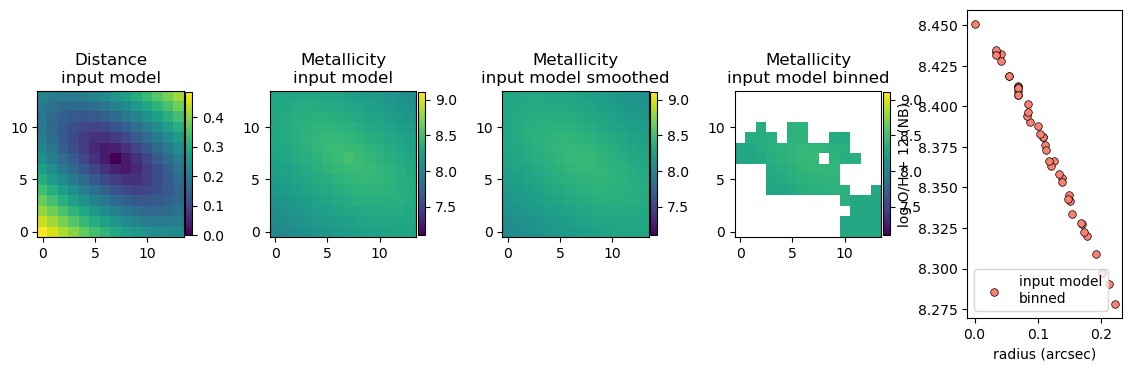

In [241]:
params_dummy = [-1, 8.5, 0.7, 45, 7, 7]
logOH_df_dummy, distance_map_dummy, logOH_map_dummy, logOH_map_dummy_smoothed, logOH_map_dummy_binned = compute_model(params_dummy, light_map, psf_array, bin_IDs_map)
logOH_df_dummy = logOH_df_dummy.rename(columns={'log_OH_model': 'log_OH'})
logOH_df_dummy['log_OH_u'] = logOH_df_dummy['log_OH'] / 10 # fake error of 10%
fig_dummy = make_param_plots(params_dummy)
np.min(logOH_map_dummy_smoothed), np.nanmin(logOH_map_dummy_smoothed)

In [264]:
pos = params_init + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(logOH_df, light_map, psf_array, bin_IDs_map, bounds))
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(logOH_df_dummy, light_map, psf_array, bin_IDs_map, bounds))
dummy = sampler.run_mcmc(pos, niter, progress=True)

100%|██████████| 5000/5000 [58:20<00:00,  1.43it/s]     


Visualising the MCMC results as corner plots

{'Zslope': 3.635900499293055, 'Zcen': 7.651707210467955, 'q': 0.6992211313124082, 'angle': 72.31069893238487}


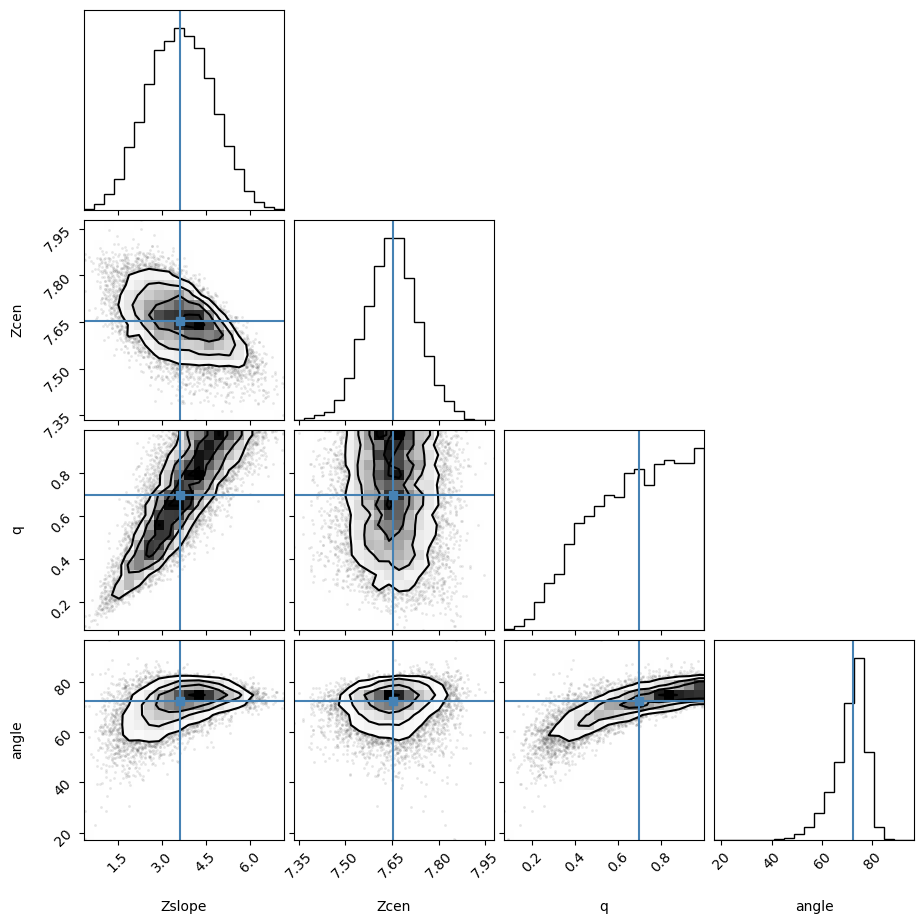

In [275]:
flat_samples = sampler.get_chain(discard=ndiscard, thin=15, flat=True)
best_fit_params = [np.median(flat_samples[:, item]) for item in range(np.shape(flat_samples)[1])]
fig_corner = corner.corner(flat_samples, labels=labels, truths=best_fit_params)
print(dict(zip(labels, best_fit_params)))

Visualising the MCMC results along with the data

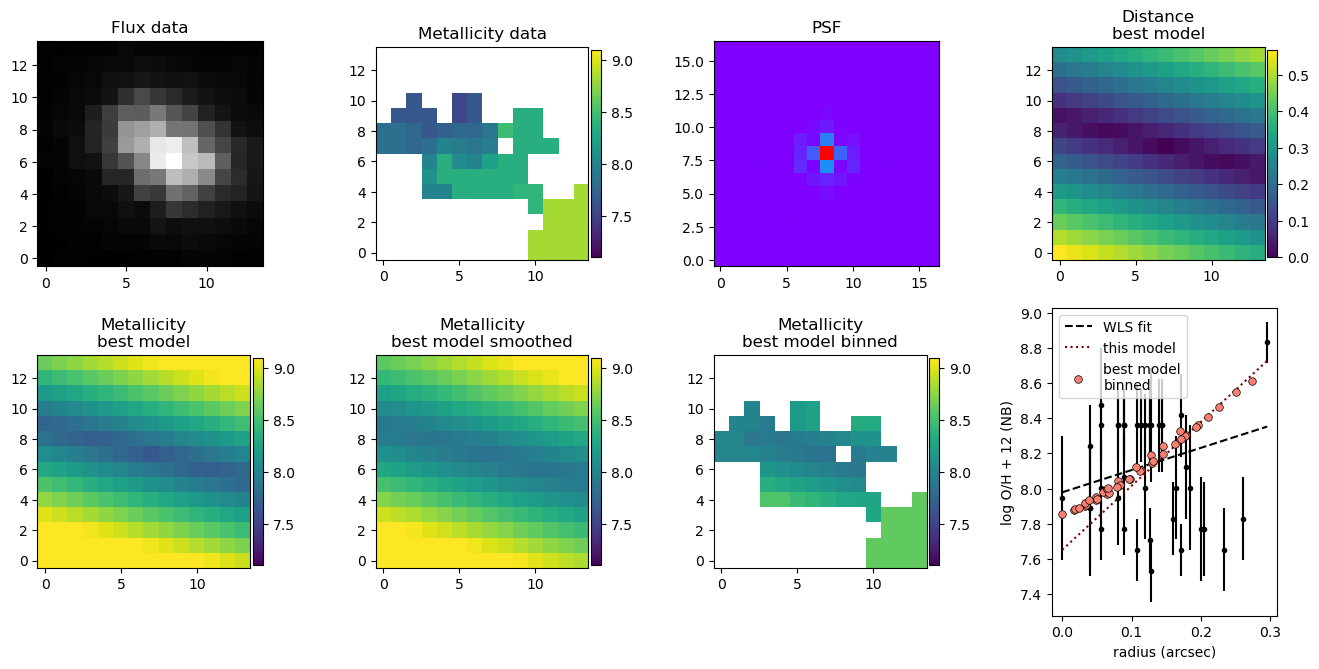

In [276]:
fig_mcmc = make_all_plots(best_fit_params)